<h1>Cardiovascular diseases</h1>

> As part of the competition in <a href="https://mlbootcamp.ru/round/12/sandbox"> mlbootcamp.ru</a>, you need to predict the presence of cardiovascular diseases based on the results of a classical medical examination. Dataset is formed from 100,000 real clinical tests.

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

    
def diff_list(list1, list2): 
    return (list(set(list1) - set(list2))) 

def feature_importances(estimator, X, y, 
                        n_features_return, plot_flag=False):
    '''Get values of features importance'''
    model = estimator
    model.fit(X, y)
    feature_importance = pd.DataFrame(data=model.feature_importances_, 
                                      index=X.columns, 
                                      columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # plot importance of features X
    if plot_flag: 
        plt.figure(figsize=(20,10))
        sns.barplot(x=feature_importance.iloc[:n_features_return, :].index, 
                    y='Importance', 
                    data=feature_importance.iloc[:n_features_return, :], 
                    color='gray', 
                    orient='v')
        plt.title('Feature importance')
        plt.tick_params(rotation=90)
    return feature_importance.index[:n_features_return]

def best_feature_subset(estimator, X, y, scorer, verbose):
    '''Perfoming a truncating of features set for different values of size'''
    error = []
    for n_features in range(1, len(X.columns)): # loop over length of possible subset
        if n_features % verbose == 0:
            print(n_features)
        new_features = feature_importances(estimator, X, y, 
                                           n_features_return=n_features, 
                                           plot_flag=False)
        X_new = X.loc[:, list(new_features)]
        score = cross_val_score(estimator=estimator, X=X_new, y=y, cv=5, 
                                scoring=scorer, n_jobs=-1)
        error.append([n_features, np.mean(score)])
    error = np.array(error)
    
    # plot errors for each length of possible subset 
    sns.lineplot(x=error[:, 0], y=error[:, 1])
    plt.xlabel('n_features')
    plt.ylabel('quality')
    plt.title('Dependance quality from number of features.')
    
def feature_importances(estimator, X, y, n_features_return, plot_flag=False):
    '''Get values of features importance'''
    model = estimator
    model.fit(X, y)
    feature_importance = pd.DataFrame(data=model.feature_importances_, 
                                      index=X.columns, 
                                      columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # plot importance of features X
    if plot_flag: 
        plt.figure(figsize=(20,10))
        sns.barplot(x=feature_importance.iloc[:n_features_return, :].index, 
                    y='Importance', 
                    data=feature_importance.iloc[:n_features_return, :], 
                    color='gray', 
                    orient='v')
        plt.title('Feature importance')
        plt.tick_params(rotation=90)
    return feature_importance.index[:n_features_return]

In [2]:
train = pd.read_csv('../input/train.csv', sep=';')
test = pd.read_csv('../input/test.csv', sep=';')

In [3]:
train.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio__
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
test.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,None,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,None,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


<h1>Exploratory Data Analysis</h1>

Check for patient ID intersection:

In [5]:
len(np.intersect1d(list(test.id), list(train.id)))

0

In [6]:
target = train.cardio__
train = train.drop(['cardio__'], axis=1)
train['dataset'] = 'train'
test['dataset'] = 'test'
all_data = pd.concat([train, test], axis=0)
all_data = all_data.reset_index()

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
index          100000 non-null int64
id             100000 non-null int64
age            100000 non-null int64
gender         100000 non-null int64
height         100000 non-null int64
weight         100000 non-null float64
ap_hi          100000 non-null int64
ap_lo          100000 non-null int64
cholesterol    100000 non-null int64
gluc           100000 non-null int64
smoke          100000 non-null object
alco           100000 non-null object
active         100000 non-null object
dataset        100000 non-null object
dtypes: float64(1), int64(9), object(4)
memory usage: 10.7+ MB


Look at the data type of columns:

In [8]:
cat_features = []
for column_name in all_data.columns:
    if all_data[column_name].dtype == 'O':
        cat_features.append(column_name)
cat_features.remove('dataset')

num_features = list(set(all_data.columns) - set(cat_features) - set(['index', 'id', 'dataset']))

In [9]:
num_features

['weight', 'age', 'ap_lo', 'height', 'cholesterol', 'ap_hi', 'gluc', 'gender']

In [10]:
Counter(all_data.smoke) # str and int object in one feature

Counter({0: 63831, 1: 6169, '0': 24601, 'None': 3030, '1': 2369})

Transform categorical values to int.

In [11]:
def type_transform(dataframe, cat_features):
    for index in dataframe.index:
        for feature_name in cat_features:
            try:
                dataframe.at[index, feature_name] = int(dataframe.at[index, feature_name])
            except:
                dataframe.at[index, feature_name] = np.nan
    return dataframe

In [12]:
all_data = type_transform(all_data, cat_features)
train = type_transform(train, cat_features)
test = type_transform(test, cat_features)

In [13]:
print('Initially NaNs in all data: {}'.format(all_data.isna().sum().sum()))

Initially NaNs in all data: 8958


It's time for some graphs.

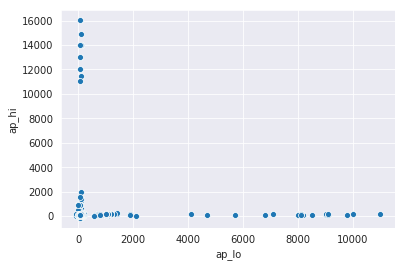

In [14]:
sns.scatterplot(data=all_data, x='ap_lo', y='ap_hi');

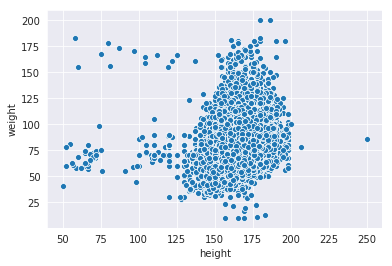

In [15]:
sns.scatterplot(data=all_data, x='height', y='weight');

In [16]:
print('Test Nans:')
test_transformed = type_transform(test, cat_features)
print(test_transformed.active.isna().sum())
print(test_transformed.smoke.isna().sum())
print(test_transformed.alco.isna().sum())

Test Nans:
2897
3030
3031


In [17]:
print('All_data Nans:')
print(all_data.active.isna().sum())
print(all_data.smoke.isna().sum())
print(all_data.alco.isna().sum())

All_data Nans:
2897
3030
3031


In [18]:
all_data.isna().sum().sum()

8958

Notes:
* 'ap_lo' and 'ap_hi' have many outliers.
* all Nans are in testing set.
* height/weight ratio can help to fix some values.

<h1>Outliers in Arterial Pressure (AP)</h1>

Making new dataset with abnormal values of arterial pressure.

In [19]:
ap_outliers = all_data[((all_data['ap_hi'] > 240) | (all_data['ap_hi'] < 40) | 
                       (all_data['ap_lo'] > 200) | (all_data['ap_lo'] < 20) | 
                       (all_data['ap_lo'] > all_data['ap_hi']))].loc[:, ['ap_hi', 'ap_lo']]

In [20]:
ap_outliers.shape

(1866, 2)

* **AP issue 1**: *ap_hi* is two-digit number (less than 18) and *ap_lo* is two-digit one (great than 30).
<br>
Solution: multiply *ap_hi* by 10.

In [21]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 2) & (x[0] < 18) & 
                (len(str(x[1])) == 2) & (x[1] > 40)) else 0, axis=1) == 1].head()

,ap_hi,ap_lo
567,14,90
927,14,90
979,11,80
1600,12,80
1627,14,80


In [22]:
index_1 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 2) & 
                        (x[0] < 18) & (len(str(x[1])) == 2) & 
                        (x[1] > 40)) else 0, axis=1) == 1].index
all_data.at[index_1, 'ap_hi'] = all_data.loc[index_1, 'ap_hi'] * 10
ap_outliers = ap_outliers.drop(index_1, axis=0)

In [23]:
ap_outliers.shape[0]

1645

* **AP issue 2**: *ap_hi* is three-digit number, but *ap_lo* is two-three-digit one.
<br>
Solution: devide *ap_lo* by 10.

In [24]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[1])) > 2) & (len(str(x[0])) > 2) &
            (x[0] < x[1]) & (x[0]*10 > x[1]) & (x[0]*3 < x[1])) else 0, axis=1) == 1].head()

,ap_hi,ap_lo
228,160,1100
241,160,1000
260,140,800
329,160,1000
345,140,1000


In [26]:
index_2 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[1])) > 2) & (x[0] < x[1]) & 
    (len(str(x[0])) > 2) & (x[0]*10 > x[1]) & (x[0]*3 < x[1])) else 0, axis=1) == 1].index
all_data.at[index_2, 'ap_lo'] = all_data.loc[index_2, 'ap_lo'] // 10
ap_outliers = ap_outliers.drop(index_2, axis=0)

In [27]:
all_data.loc[index_2, ['ap_hi', 'ap_lo']].head(5)

,ap_hi,ap_lo


* **AP issue 3**: *ap_hi* is 4-digit number, *ap_lo* - 2.
<br>
Solution: deviding *ap_hi* by 10.

In [28]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 4) & (len(str(x[1])) == 2) &
                (x[0] > 0) & (x[1] > 0)) else 0, axis=1) == 1]

,ap_hi,ap_lo
8915,1420,80
13895,1500,80
25780,1400,80
28147,1620,80
36894,1130,90
41095,1202,80
43133,1400,90
43208,1420,80
43504,1300,80
48795,1400,90


In [29]:
index_3 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 4) & 
            (len(str(x[1])) == 2) & (x[0] > 0) & (x[1] > 0)) else 0, axis=1) == 1].index
all_data.at[index_3, 'ap_hi'] = all_data.loc[index_3, 'ap_hi'] // 10
ap_outliers = ap_outliers.drop(index_3, axis=0)

In [30]:
all_data.loc[index_3, ['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
8915,142,80
13895,150,80
25780,140,80
28147,162,80
36894,113,90
41095,120,80
43133,140,90
43208,142,80
43504,130,80
48795,140,90


* **AP issue 4**: *ap_lo* has 4 digits, *ap_hi* - 3.
<br>
Solution: deviding *ap_lo* by 100.

In [31]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[1])) == 4) & (len(str(x[0])) == 3) &
                (x[0] > 0) & (x[1] > 0) & (x[1] > 5000)) else 0, axis=1) == 1]

,ap_hi,ap_lo
2985,140,8044
6653,130,9100
9165,120,8000
12086,130,9011
14308,160,7100
15990,120,8500
17738,140,8099
20882,160,8100
23230,112,5700
23502,120,8079


In [32]:
index_4 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[1])) == 4) & (len(str(x[0])) == 3) &
                          (x[0] > 0) & (x[1] > 0) & (x[1] > 5000)) else 0, axis=1) == 1].index

In [33]:
all_data.at[index_4, 'ap_lo'] = all_data.loc[index_4, 'ap_lo'] // 100
ap_outliers = ap_outliers.drop(index_4, axis=0)

In [34]:
all_data.loc[index_4, ['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
2985,140,80
6653,130,91
9165,120,80
12086,130,90
14308,160,71
15990,120,85
17738,140,80
20882,160,81
23230,112,57
23502,120,80


* **AP issue 5**: *ap_hi* has 5 digits, *ap_lo* - 2.
<br>
Solution: deviding *ap_hi* by 100.

In [35]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 5) & 
                (x[0] > 0) & (x[1] > 0)) else 0, axis=1) == 1]

,ap_hi,ap_lo
7763,11500,90
25464,14020,80
25519,14020,80
40852,16020,80
46912,14020,90
47253,14020,90
51438,11020,80
55459,13010,80
55847,13010,80
75176,12008,80


In [36]:
index_5 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 5) & (x[0] > 0) &
                          (x[1] > 0)) else 0, axis=1) == 1].index
all_data.at[index_5, 'ap_hi'] = all_data.loc[index_5, 'ap_hi'] // 100
ap_outliers = ap_outliers.drop(index_5, axis=0)

In [37]:
all_data.loc[index_5, ['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
7763,115,90
25464,140,80
25519,140,80
40852,160,80
46912,140,90
47253,140,90
51438,110,80
55459,130,80
55847,130,80
75176,120,80


* **AP issue 6**: swap.
<br>
Solution: swap.

In [38]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((x[1] > x[0]) & (x[1] - x[0] < 100) &
                (x[0] > 40) & (x[1] > 0)) else 0, axis=1) == 1].head()

,ap_hi,ap_lo
474,120,150
636,70,110
2384,90,150
2990,80,140
3447,80,125


In [39]:
index_6 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((x[1] > x[0]) & (x[0] > 40) &
                (x[1] - x[0] < 100) & (x[1] > 0)) else 0, axis=1) == 1].index
temp = all_data.loc[index_6, 'ap_hi']
all_data.at[index_6, 'ap_hi'] = all_data.loc[index_6, 'ap_lo']
all_data.at[index_6, 'ap_lo'] = temp

In [40]:
ap_outliers = ap_outliers.drop(index_6, axis=0)

* **AP issue 7**: *ap_hi* is ###, *ap_lo* is #.
<br>
Solution: *ap_lo* mul by 10

In [41]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[1])) == 1) & 
                (x[1] > 0)) else 0, axis=1) == 1]

,ap_hi,ap_lo
7598,120,8
9777,120,8
18898,110,7
19075,110,7
28065,90,6
35140,130,1
38599,120,9
68568,110,6
76870,110,7
86009,100,6


In [42]:
index_7 = ap_outliers[ap_outliers.apply(lambda x: 1 if (len(str(x[1])) == 1) & (x[1] > 0)
                                                    else 0, axis=1) == 1].index
all_data.at[index_7, 'ap_lo'] = all_data.loc[index_7, 'ap_lo'] * 10
ap_outliers = ap_outliers.drop(index_7, axis=0)

In [43]:
all_data.loc[index_7, ['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
7598,120,80
9777,120,80
18898,110,70
19075,110,70
28065,90,60
35140,130,10
38599,120,90
68568,110,60
76870,110,70
86009,100,60


* **AP issue 8**: *ap_hi* or *ap_lo* less then 0.
<br>
Solution: mul by -1

In [44]:
ap_outliers[ap_outliers.apply(lambda x: 1 if (x[0] < 0) | (x[1] < 0) else 0, axis=1) == 1]

,ap_hi,ap_lo
4607,-100,80
16021,-115,70
20536,-100,70
23988,-140,90
25240,-120,80
35040,-150,80
46627,-120,80
60106,15,-70
91811,-130,80
92231,-12,80


In [45]:
index_8 = ap_outliers[ap_outliers.apply(lambda x: 1 if (x[0] < 0) | (x[1] < 0)
                                                    else 0, axis=1) == 1].index
all_data.at[index_8, ['ap_hi', 'ap_lo']] = abs(all_data.loc[index_8, ['ap_hi', 'ap_lo']])

In [46]:
all_data.at[60106, 'ap_hi'] = all_data.loc[60106, 'ap_hi'] * 10
all_data.at[92231, 'ap_hi'] = all_data.loc[92231, 'ap_hi'] * 10

In [47]:
ap_outliers = ap_outliers.drop(index_8, axis=0)

* **AP issue 9**: *ap_hi* = ### > 900, *ap_lo* = ##.
<br>
Solution: *ap_hi* // 10

In [49]:
ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 3) & 
                (len(str(x[1])) == 2) & (x[0] > 900)) else 0, axis=1) == 1]

,ap_hi,ap_lo
1876,902,60
4817,909,60
17713,907,70
29665,907,70
42658,906,60
53982,960,60
64911,906,60
71685,907,70
76958,957,70
77463,906,60


In [50]:
index_9 = ap_outliers[ap_outliers.apply(lambda x: 1 if ((len(str(x[0])) == 3) &
                    (len(str(x[1])) == 2) & (x[0] > 900)) else 0, axis=1) == 1].index
all_data.at[index_9, 'ap_hi'] = all_data.loc[index_9, 'ap_hi'] // 10

In [51]:
all_data.loc[index_9, 'ap_hi']

1876     90
4817     90
17713    90
29665    90
42658    90
53982    96
64911    90
71685    90
76958    95
77463    90
79262    90
96412    90
Name: ap_hi, dtype: int64

In [52]:
ap_outliers = ap_outliers.drop(index_9, axis=0)

In [53]:
all_data.at[70303, ['ap_hi', 'ap_lo']] = [0, 0]

In [54]:
all_data.at[70303, ['ap_hi', 'ap_lo']] = [60, 40]
all_data.at[71929, ['ap_hi', 'ap_lo']] = [110, 99]
all_data.at[72220, ['ap_hi', 'ap_lo']] = [120, 110]
all_data.at[72443, ['ap_hi', 'ap_lo']] = [160, 100]
all_data.at[72943, ['ap_hi', 'ap_lo']] = [120, 80]
all_data.at[73160, ['ap_hi', 'ap_lo']] = [170, 100]
all_data.at[75436, ['ap_hi', 'ap_lo']] = [120, 110]
all_data.at[76400, ['ap_hi', 'ap_lo']] = [160, 10]
all_data.at[77638, ['ap_hi', 'ap_lo']] = [130, 100]
all_data.at[77906, ['ap_hi', 'ap_lo']] = [120, 100]
all_data.at[78295, ['ap_hi', 'ap_lo']] = [170, 120]
all_data.at[81068, ['ap_hi', 'ap_lo']] = [140, 100]
all_data.at[82852, ['ap_hi', 'ap_lo']] = [130, 90]
all_data.at[83138, ['ap_hi', 'ap_lo']] = [100, 80]
all_data.at[83629, ['ap_hi', 'ap_lo']] = [125, 100]
all_data.at[85437, ['ap_hi', 'ap_lo']] = [100, 80]
all_data.at[85510, ['ap_hi', 'ap_lo']] = [120, 88]
all_data.at[87406, ['ap_hi', 'ap_lo']] = [120, 90]
all_data.at[88857, ['ap_hi', 'ap_lo']] = [90, 50]
all_data.at[89712, ['ap_hi', 'ap_lo']] = [190, 80]
all_data.at[94538, ['ap_hi', 'ap_lo']] = [100, 80]
all_data.at[95015, ['ap_hi', 'ap_lo']] = [160, 100]
all_data.at[95932, ['ap_hi', 'ap_lo']] = [170, 100]
all_data.at[99327, ['ap_hi', 'ap_lo']] = [118, 100]
all_data.at[99333, ['ap_hi', 'ap_lo']] = [115, 70]
all_data.at[99982, ['ap_hi', 'ap_lo']] = [90, 60]

In [55]:
target = target.drop(ap_outliers.index[ap_outliers.index < 70000])
all_data = all_data.drop(ap_outliers.index[ap_outliers.index < 70000], axis=0)

In [56]:
all_data[all_data['ap_lo'] < 30][['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
8797,110,20
11820,128,20
13935,110,20
18958,110,20
20135,110,20
22380,120,20
23305,120,20
24757,120,20
35140,130,10
39896,120,20


In [57]:
index_10 = all_data[all_data['ap_lo'] < 30].index
temp = all_data.loc[index_10, 'ap_hi']
all_data.at[index_10, 'ap_hi'] = all_data.loc[index_10, 'ap_lo'] * 10
all_data.at[index_10, 'ap_lo'] = temp

<h1>Height/weight</h1>

Create some new features for convenience.

In [58]:
all_data['height_metres'] = all_data['height'] / 100
all_data['age_years'] = all_data['age'] / 365
all_data['body_mass_index'] = all_data['weight'] / all_data['height_metres']**2

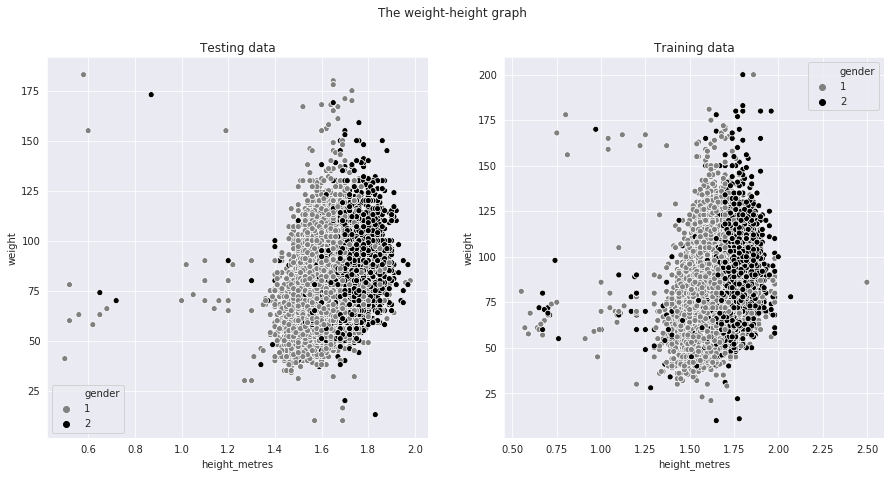

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
sns.scatterplot(data=all_data[all_data.dataset=='test'], 
                x='height_metres', 
                y='weight', 
                hue='gender', 
                palette={1: 'gray', 2: 'black'},
                ax=ax[0])
sns.scatterplot(data=all_data[all_data.dataset=='train'], 
                x='height_metres', 
                y='weight', 
                hue='gender', 
                palette={1: 'gray', 2: 'black'},
                ax=ax[1])
fig.suptitle('The weight-height graph')
ax[0].title.set_text('Testing data')
ax[1].title.set_text('Training data')
fig.show()

* **Issue 1**: all_data.height < 96 and all_data.weight < 100.

In [60]:
all_data[(all_data.height < 96) & (all_data.weight < 100)][['gender', 
                                                            'height',
                                                            'height_metres',
                                                            'weight', 
                                                            'age_years']].head()

,gender,height,height_metres,weight,age_years
224,2,76,0.76,55.0,59.726027
7598,2,70,0.70,72.0,40.167123
13265,2,71,0.71,68.0,61.523288
14323,1,67,0.67,57.0,60.287671
15167,1,70,0.70,68.0,43.320548


In [61]:
index_1 = all_data[(all_data.height < 96) & (all_data.weight < 100)].index
all_data.at[index_1, 'height'] = all_data.loc[index_1, 'height'] + 100

**Issue 2**: 95 < all_data.height < 130 and 30 < all_data.weight < 100.

In [62]:
all_data[((all_data.dataset == 'test') & (all_data.height > 95) & (all_data.height < 130) &
         (all_data.weight < 100) & (all_data.weight > 30))][['gender', 
                                                            'height_metres',
                                                            'weight', 
                                                            'age_years']]

,gender,height_metres,weight,age_years
70195,1,1.10,90.0,52.038356
70817,1,1.16,70.0,57.926027
73089,1,1.00,70.0,53.920548
74769,2,1.20,80.0,49.852055
75002,1,1.20,65.0,50.079452
77733,1,1.10,80.0,44.627397
81766,1,1.14,66.0,54.832877
82175,1,1.22,88.0,43.405479
82567,1,1.10,70.0,63.805479
84918,2,1.20,70.0,59.652055


In [63]:
index_2 = all_data[((all_data.dataset == 'test') & (all_data.height > 95) &
            (all_data.height < 130) & (all_data.weight < 100) & (all_data.weight > 30))].index

In [64]:
median_height = lambda x: all_data.groupby(['gender', 'weight']) \
                          .agg({"height": "median"}).loc[x[0], x[1]]
all_data.at[index_2, 'height'] = all_data.loc[index_2, ['gender', 'weight']] \
                          .apply(median_height, axis=1)

* **Issue 3**: all_data.height < 125 and  150 < all_data.weight

In [65]:
all_data[(all_data.height < 125) & (all_data.weight > 150)][['gender', 
                                                            'height_metres',
                                                            'weight', 
                                                            'age_years']]

,gender,height_metres,weight,age_years
6153,1,1.22,161.0,57.506849
8171,2,0.97,170.0,48.345205
12770,1,0.75,168.0,53.682192
20028,1,1.12,167.0,54.183562
23913,1,0.81,156.0,52.257534
27384,1,0.80,178.0,41.895890
45358,1,1.04,159.0,54.339726
59625,1,1.04,165.0,48.336986
70730,1,0.58,183.0,59.646575
85109,1,0.60,155.0,62.112329


In [66]:
index_3 = all_data[(all_data.height < 125) & (all_data.weight > 150)].index

In [67]:
temp = all_data.loc[index_3, 'weight']
all_data.at[index_3, 'weight'] = all_data.loc[index_3, 'height']
all_data.at[index_3, 'height'] = temp

In [68]:
all_data.loc[index_3, ['weight', 'height']]

,weight,height
6153,122.0,161.0
8171,97.0,170.0
12770,75.0,168.0
20028,112.0,167.0
23913,81.0,156.0
27384,80.0,178.0
45358,104.0,159.0
59625,104.0,165.0
70730,58.0,183.0
85109,60.0,155.0


* **Issue 5:** all_data.weight < 25.

In [69]:
all_data[all_data.weight < 25][['gender', 
                                'height_metres',
                                'weight', 
                                'age_years']]

,gender,height_metres,weight,age_years
26806,1,1.57,23.0,63.791781
29488,2,1.77,22.0,55.912329
33817,2,1.78,11.0,59.128767
57858,2,1.65,10.0,51.517808
60188,1,1.62,21.0,59.876712
70259,2,1.83,13.0,41.608219
72317,1,1.57,10.0,54.205479
86349,1,1.69,16.3,43.884932
87418,2,1.70,20.0,40.679452
98825,1,1.69,10.0,52.126027


In [70]:
index_5 = all_data[all_data.weight < 25].index

In [72]:
median_weight = lambda x: all_data.groupby(['gender', 'height']) \
                          .agg({"weight": "median"}).loc[x[0], x[1]]
all_data.at[index_5, 'weight'] = all_data.loc[index_5, ['gender', 'height']] \
                          .apply(median_weight, axis=1)

In [73]:
all_data.loc[index_5, 'weight']

26806    69.0
29488    83.5
33817    82.0
57858    69.0
60188    70.5
70259    89.0
72317    69.0
86349    71.0
87418    75.0
98825    71.0
Name: weight, dtype: float64

* **Issue 6:** other outliers.

In [74]:
index_6 = all_data[((all_data.dataset == 'train') & ((all_data.height < 120) |
    (all_data.height > 200) | (all_data.height < 140) & (all_data.weight > 150)))].index

In [75]:
all_data = all_data.drop(index_6, axis=0)
target = target.drop(index_6, axis=0)

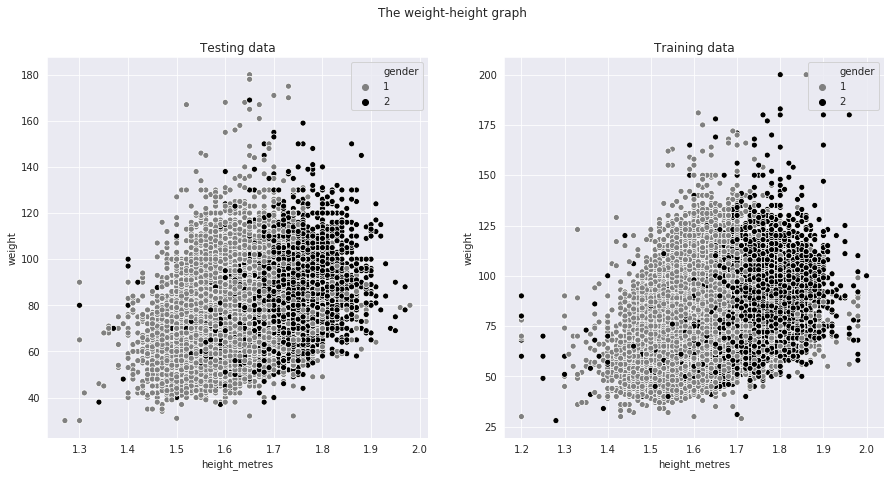

In [76]:
all_data['height_metres'] = all_data['height'] / 100

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
sns.scatterplot(data=all_data[all_data.dataset=='test'], 
                x='height_metres', 
                y='weight', 
                hue='gender', 
                palette={1: 'gray', 2: 'black'},
                ax=ax[0])
sns.scatterplot(data=all_data[all_data.dataset=='train'], 
                x='height_metres', 
                y='weight', 
                hue='gender', 
                palette={1: 'gray', 2: 'black'},
                ax=ax[1])
fig.suptitle('The weight-height graph')
ax[0].title.set_text('Testing data')
ax[1].title.set_text('Training data')
fig.show()

The graph looks acceptable.

<h1>New features</h1>

In [77]:
all_data['age_years'] = all_data['age'] / 365
all_data['height_metres'] = all_data['height'] / 100
all_data['body_mass_index'] = all_data['weight'] / all_data['height_metres']**2
all_data['body_mass_index_category'] = pd.cut(all_data['body_mass_index'], 
                                              bins = [0, 15., 16., 18.5, 25., 30., 
                                                      35., 40., 45., 50., 60., np.Inf])
all_data['age_category'] = pd.cut(all_data['age_years'], bins=[10, 20, 30, 40, 50, 60, 70])
all_data['diff_ap_hi_ap_lo'] = all_data['ap_hi'] - all_data['ap_lo']

> <a href="https://en.wikipedia.org/wiki/Body_mass_index">The body mass index (BMI)</a> (or Quetelet index) is a value derived from the mass (weight) and height of a person. The BMI is defined as the body mass divided by the square of the body height, and is universally expressed in units of kg/m2, resulting from mass in kilograms and height in metres. 

Apply next table to make categories of BMI:

<table class="wikitable">

<tbody><tr>
<th>Category
</th>
<th colspan="2">BMI (kg/m<sup>2</sup>)
</th>
<th colspan="2">BMI Prime
</th></tr>
<tr>
<td>
</td>
<th>from</th>
<th>to
</th>
<th>from</th>
<th>to
</th></tr>
<tr>
<td>Very severely underweight
</td>
<td></td>
<td>15
</td>
<td></td>
<td>0.60
</td></tr>
<tr>
<td>Severely underweight
</td>
<td>15</td>
<td>16
</td>
<td>0.60</td>
<td>0.64
</td></tr>
<tr>
<td>Underweight
</td>
<td>16</td>
<td>18.5
</td>
<td>0.64</td>
<td>0.74
</td></tr>
<tr>
<td>Normal (healthy weight)
</td>
<td>18.5</td>
<td>25
</td>
<td>0.74</td>
<td>1.0
</td></tr>
<tr>
<td>Overweight
</td>
<td>25</td>
<td>30
</td>
<td>1.0</td>
<td>1.2
</td></tr>
<tr>
<td>Obese Class I (Moderately obese)
</td>
<td>30</td>
<td>35
</td>
<td>1.2</td>
<td>1.4
</td></tr>
<tr>
<td>Obese Class II (Severely obese)
</td>
<td>35</td>
<td>40
</td>
<td>1.4</td>
<td>1.6
</td></tr>
<tr>
<td>Obese Class III (Very severely obese)
</td>
<td>40</td>
<td>45
</td>
<td>1.6</td>
<td>1.8
</td></tr>
<tr>
<td>Obese Class IV (Morbidly Obese)
</td>
<td>45</td>
<td>50
</td>
<td>1.8</td>
<td>2
</td></tr>
<tr>
<td>Obese Class V (Super Obese)
</td>
<td>50</td>
<td>60
</td>
<td>2</td>
<td>2.4
</td></tr>
<tr>
<td>Obese Class VI (Hyper Obese)
</td>
<td>60</td>
<td>
</td>
<td>2.4</td>
<td>
</td></tr></tbody></table>

There are no any comments about correspondence between {1, 2} and real gender. Find out it by looking to median of height and weight. <br>
I guess that label '1' is for women, '2' - for man.

In [78]:
print(all_data.weight[all_data.gender == 1].median())
print(all_data.height[all_data.gender == 1].median())
print(all_data.weight[all_data.gender == 2].median())
print(all_data.height[all_data.gender == 2].median())

70.0
161.0
75.0
170.0


Add deviation of AP from normal values:

In [79]:
ap_normal_males = pd.DataFrame({'ap_hi': [123, 126, 129, 135, 142, 145, 147],
                                'ap_lo': [76, 79, 81, 83, 85, 82, 82]},
                               index=range(1, 8))
ap_normal_females = pd.DataFrame({'ap_hi': [116, 120, 127, 137, 144, 159, 157],
                                  'ap_lo': [72, 75, 80, 84, 85, 85, 83]},
                                 index=range(1, 8))

In [80]:
ap_normal_females

,ap_hi,ap_lo
1,116,72
2,120,75
3,127,80
4,137,84
5,144,85
6,159,85
7,157,83


In [81]:
ap_normal_males

,ap_hi,ap_lo
1,123,76
2,126,79
3,129,81
4,135,83
5,142,85
6,145,82
7,147,82


In [82]:
def mean_arterial_pressure(age, gender): # gender: 1 - female, 2 - male
    '''Returns normal arterial pressure for age and pressure'''
    if age < 10 or age > 70:
        print('Age less than 10 or over 70.')
        return [0, 0]
    age_index = np.floor(age/10) 
    if gender == 2: # males
        return list(ap_normal_males.loc[age_index, :])
    if gender == 1: # females
        return list(ap_normal_females.loc[age_index, :])
    else: 
        return [0, 0]

In [83]:
ap_norm = list(all_data[['age_years', 'gender']] \
               .apply(lambda x: mean_arterial_pressure(x.age_years, x.gender), axis=1))
all_data['normal_ap_hi'] = np.array(ap_norm)[:, 0]
all_data['normal_ap_lo'] = np.array(ap_norm)[:, 1]

In [84]:
all_data['deviation_from_ap_hi'] = all_data['ap_hi'] - all_data['normal_ap_hi']
all_data['deviation_from_ap_lo'] = all_data['ap_lo'] - all_data['normal_ap_lo']

Create dummies for body_mass_index_category and age_category:

In [85]:
all_data = pd.concat([all_data, 
                      pd.get_dummies(all_data['body_mass_index_category'], 
                                     prefix='BMI_cat')], 
                     axis=1)
all_data = pd.concat([all_data, 
                      pd.get_dummies(all_data['age_category'], 
                                     prefix='age_cat')], 
                     axis=1)
all_data = all_data.drop(['age_category', 'body_mass_index_category', 'index', 'id'], axis=1)

Rename columns:

In [86]:
new_feature_names = []
for name in all_data.columns:
    name = name.replace(' ', '_')
    name = name.replace('(', '')
    name = name.replace(']', '')
    new_feature_names.append(name)

In [87]:
all_data = all_data.rename(columns=dict(zip(all_data.columns, new_feature_names)))

 <h1>Models</h1>

Drop smoke, alco, active.

In [88]:
features_default = ['age', 'gender', 'height', 'weight', 
                    'ap_hi', 'ap_lo', 'cholesterol', 'gluc']

In [89]:
train_baseline = all_data[all_data.dataset == 'train'].loc[:, features_default]
test_baseline = all_data[all_data.dataset == 'test'].loc[:, features_default]

For initially columns (age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc):

In [90]:
all_data.isna().sum().sum()

8958

In [91]:
X_train, X_test, y_train, y_test = train_test_split(train_baseline, 
                                                    target, 
                                                    test_size=0.2)
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Logloss:  0.5561124731708854


<h4>Fill nans with the most frequent value. Default features.</h4>

In [92]:
print(Counter(all_data['active']))
print(Counter(all_data['smoke']))
print(Counter(all_data['alco']))

Counter({1: 78030, 0: 18986, nan: 2897})
Counter({0: 88350, 1: 8533, nan: 3030})
Counter({0: 91655, 1: 5227, nan: 3031})


In [93]:
all_data['alco_smoke_flag'] = all_data['alco']*all_data['smoke']
all_data_filled = all_data.copy()
all_data_filled['active'] = all_data['active'].fillna(1)
all_data_filled['smoke'] = all_data['smoke'].fillna(0)
all_data_filled['alco'] = all_data['alco'].fillna(0)
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 
            'ap_lo', 'cholesterol', 'gluc', 'active', 'smoke', 'alco']
train_baseline = all_data_filled[all_data_filled.dataset == 'train'].loc[:, features]
test_baseline = all_data_filled[all_data_filled.dataset == 'test'].loc[:, features]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(train_baseline, 
                                                    target, 
                                                    test_size=0.2)
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Logloss:  0.5596108629365203


Consider all features:

In [95]:
features = diff_list(list(all_data.columns), ['index', 'id', 'body_mass_index_category', 
                                              'dataset', 'age_category'])
train_baseline = all_data_filled[all_data_filled.dataset == 'train'].loc[:, features]
test_baseline = all_data_filled[all_data_filled.dataset == 'test'].loc[:, features]

In [96]:
train_baseline.head()

,weight,normal_ap_hi,ap_lo,"BMI_cat_50.0,_60.0","BMI_cat_40.0,_45.0",cholesterol,height_metres,ap_hi,"BMI_cat_30.0,_35.0","BMI_cat_35.0,_40.0","BMI_cat_18.5,_25.0","age_cat_60,_70",smoke,"age_cat_50,_60",age,"BMI_cat_45.0,_50.0","age_cat_30,_40","age_cat_20,_30",body_mass_index,"BMI_cat_0.0,_15.0","age_cat_10,_20",gluc,"BMI_cat_15.0,_16.0",age_years,deviation_from_ap_hi,diff_ap_hi_ap_lo,height,alco_smoke_flag,gender,"BMI_cat_60.0,_inf",deviation_from_ap_lo,"BMI_cat_16.0,_18.5","age_cat_40,_50",alco,normal_ap_lo,"BMI_cat_25.0,_30.0",active
0,62.0,142,80,0,0,1,1.68,110,0,0,1,0,0,1,18393,0,0,0,21.967120,0,0,1,0,50.391781,-32,30,168.0,0,2,0,-5,0,0,0,85,0,1
1,85.0,144,90,0,0,3,1.56,140,1,0,0,0,0,1,20228,0,0,0,34.927679,0,0,1,0,55.419178,-4,50,156.0,0,1,0,5,0,0,0,85,0,1
2,64.0,144,70,0,0,3,1.65,130,0,0,1,0,0,1,18857,0,0,0,23.507805,0,0,1,0,51.663014,-14,60,165.0,0,1,0,-15,0,0,0,85,0,0
3,82.0,135,100,0,0,1,1.69,150,0,0,0,0,0,0,17623,0,0,0,28.710479,0,0,1,0,48.282192,15,50,169.0,0,2,0,17,0,1,0,83,1,1
4,56.0,137,60,0,0,1,1.56,100,0,0,1,0,0,0,17474,0,0,0,23.011177,0,0,1,0,47.873973,-37,40,156.0,0,1,0,-24,0,1,0,84,0,0


In [97]:
train_baseline.shape

(69913, 37)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(train_baseline, 
                                                    target, 
                                                    test_size=0.2, 
                                                    shuffle=True)
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

<h3>Default models</h3>

In [99]:
logreg = LogisticRegression() 
scores = cross_val_score(logreg, 
                         X_train_scaled, 
                         y_train, 
                         scoring='neg_log_loss', 
                         cv=10)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.55666 +- 0.01107


In [100]:
xgboost = XGBClassifier()
scores = cross_val_score(xgboost, 
                         X_train_scaled, 
                         y_train, 
                         scoring='neg_log_loss', 
                         cv=10, 
                         n_jobs=-1)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.53834 +- 0.01233


In [101]:
xgboost = XGBClassifier()
xgboost.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, xgboost.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6973
           1       0.75      0.69      0.72      7010

    accuracy                           0.73     13983
   macro avg       0.73      0.73      0.73     13983
weighted avg       0.73      0.73      0.73     13983



<h1>Feature selecting</h1>

Choose the best subset of features:

10
20
30


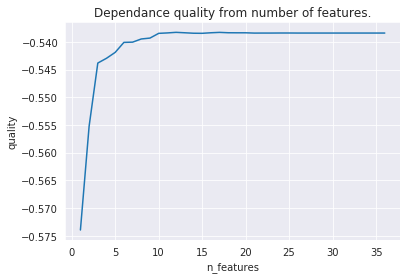

In [102]:
X_train_scaled_pd = pd.DataFrame(X_train_scaled, columns=train_baseline.columns)
xgboost = XGBClassifier()
best_feature_subset(xgboost, X_train_scaled_pd, y_train, 'neg_log_loss', verbose=10)

Truncate features to top-20:

Index(['ap_hi', 'age', 'cholesterol', 'ap_lo', 'active', 'body_mass_index',
       'weight', 'smoke', 'alco_smoke_flag', 'gluc', 'gender',
       'age_cat_50,_60', 'alco', 'deviation_from_ap_hi', 'normal_ap_hi',
       'diff_ap_hi_ap_lo', 'deviation_from_ap_lo', 'height_metres',
       'BMI_cat_35.0,_40.0', 'height'],
      dtype='object')


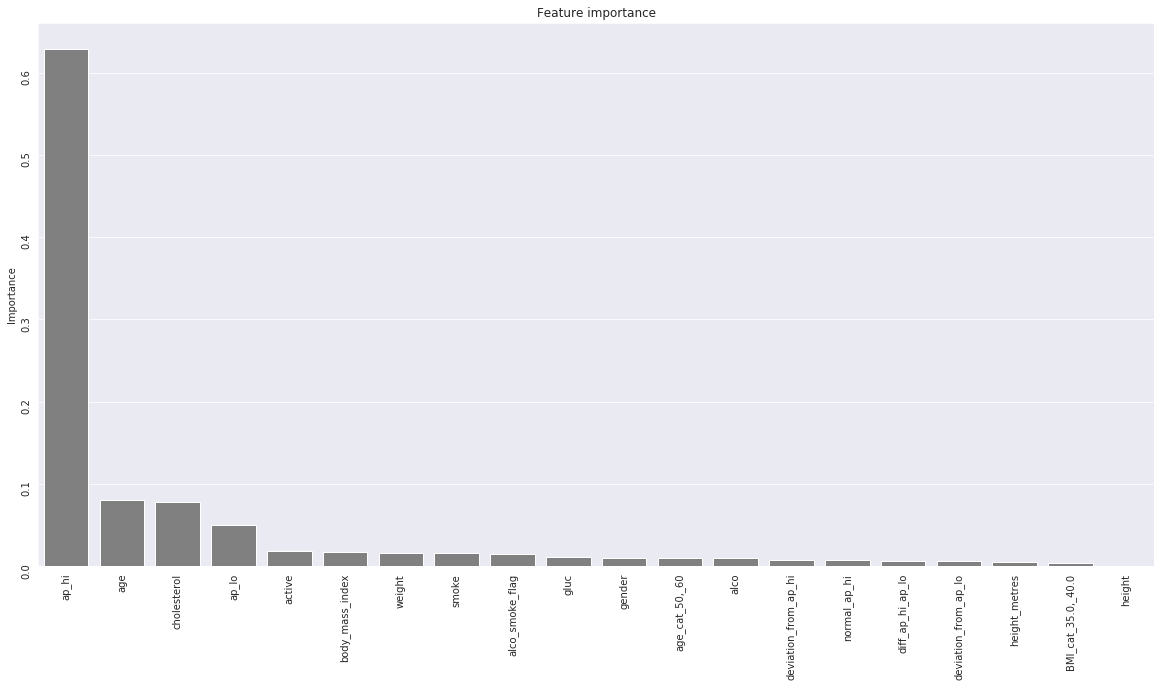

In [103]:
truncated_features = feature_importances(estimator=xgboost, 
                                         X=X_train_scaled_pd, 
                                         y=y_train, 
                                         n_features_return=20, 
                                         plot_flag=False)
feature_importances(estimator=xgboost, 
                    X=X_train_scaled_pd, 
                    y=y_train, 
                    n_features_return=20, 
                    plot_flag=True);
print(truncated_features)

In [104]:
train_baseline = all_data_filled[all_data_filled.dataset == 'train'].loc[:, truncated_features]
test_baseline = all_data_filled[all_data_filled.dataset == 'test'].loc[:, truncated_features]
X_train, X_test, y_train, y_test = train_test_split(train_baseline, 
                                                    target, 
                                                    test_size=0.2, 
                                                    shuffle=True)
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [105]:
logreg = LogisticRegression() 
scores = cross_val_score(logreg, X_train_scaled, y_train, scoring='neg_log_loss', cv=10)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.55721 +- 0.00976


In [106]:
xgboost = XGBClassifier()
scores = cross_val_score(xgboost, 
                         X_train_scaled, 
                         y_train, 
                         scoring='neg_log_loss', 
                         cv=10, 
                         n_jobs=-1)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.53863 +- 0.01042


<h1>More detail fitting of models</h1>

<h3>Logistic Regression</h3>

In [110]:
grid_params=[{'penalty': ['elasticnet'],
              'solver': ['saga'],
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
             'l1_ratio': [0.001, 0.01, 0.1, 0.5]},
             {'penalty': ['l1', 'l2'],
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

log_reg = LogisticRegression(C=1.0, 
                             intercept_scaling=1,   
                             dual=False, 
                             fit_intercept=True, 
                             penalty='l2',
                             tol=0.0001,
                             random_state=42) 
grid_search = GridSearchCV(estimator=log_reg, 
                           param_grid=grid_params, 
                           cv=5, 
                           scoring='neg_log_loss', 
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])

Best_params:  {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Best score:  -0.5572254542766443
Mean_test_score for all parameters:  [-0.5704303  -0.57120248 -0.58038316 -0.63841824 -0.55789249 -0.55792117
 -0.55830747 -0.56096387 -0.55736946 -0.55736903 -0.55736818 -0.55739664
 -0.5572499  -0.5572502  -0.55725371 -0.55729057 -0.55722609 -0.55722607
 -0.55722593 -0.55722545 -0.55722732 -0.55722732 -0.5572273  -0.55722717
 -0.69314718 -0.57039441 -0.56452535 -0.55789865 -0.55752212 -0.55736974
 -0.55733201 -0.5572515  -0.55723132 -0.55722661 -0.55722833 -0.55722803]


Terminal params for Logistic Regression:

In [111]:
log_reg = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(log_reg, 
                         X_train_scaled, 
                         y_train, 
                         scoring='neg_log_loss', 
                         cv=10, 
                         n_jobs=-1)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.55721 +- 0.00976


<h3>Random Forest</h3>

In [113]:
rand_forest_clf = RandomForestClassifier(n_estimators=1500, 
                                         max_depth=6,
                                         min_samples_split=4,
                                         min_samples_leaf=4,
                                         max_features='sqrt',
                                         random_state=0)
scores = cross_val_score(rand_forest_clf, 
                         X_train_scaled, 
                         y_train, 
                         scoring='neg_log_loss', 
                         cv=10, 
                         n_jobs=-1)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.54651 +- 0.00955


Let's use RandomizedSearchCV:

In [114]:
%%time
grid_params = {'bootstrap': [True, False],
               'max_depth': [4, 6, 10, 12, 15, 20],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600, 1000, 1200, 1600, 2000]}
grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                                 param_distributions=grid_params, 
                                 cv=5,
                                 n_iter=10,   # only 10 iterations for demonstration
                                 scoring='neg_log_loss', 
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=2)
grid_search.fit(X_train_scaled, y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.3min finished


Best_params:  {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 12, 'bootstrap': False}
Best score:  -0.5414420154952199
Mean_test_score for all parameters:  [-0.54547877 -0.55584912 -0.54671863 -0.55574784 -0.54144202 -0.54676646
 -0.54227652 -0.55062847 -0.54556438 -0.54666234]
CPU times: user 1min 13s, sys: 288 ms, total: 1min 13s
Wall time: 29min 32s


In [116]:
rand_forest_clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
scores = cross_val_score(rand_forest_clf, 
                         X_train_scaled, 
                         y_train, 
                         scoring='neg_log_loss', 
                         cv=10, 
                         n_jobs=-1)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.54077 +- 0.01158


<h3>XGBoost</h3>

In [117]:
#RandomizedSearchCV for XGBoost

grid_params = {
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'min_samples_split': [1, 2, 3, 4, 6, 10],
    'min_samples_leaf': [1, 2, 3, 4, 6, 10],
    'max_depth': [3, 5, 8, 10],
    'max_features':['log2','sqrt'],
    'subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    'n_estimators':[10, 50 ,100, 150]
    }

grid_search = RandomizedSearchCV(estimator=XGBClassifier(), 
                                 param_distributions=grid_params, 
                                 cv=5,
                                 n_iter=10,
                                 scoring='neg_log_loss', 
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=4)
grid_search.fit(X_train_scaled, y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


Best_params:  {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}
Best score:  -0.538685306454843
Mean_test_score for all parameters:  [-0.56021223 -0.56707981 -0.6020957  -0.55164195 -0.56720182 -0.66772527
 -0.53868531 -0.6698102  -0.56720152 -0.60204039]


Apply a consistent tuning of parameters for XGBoost:

In [118]:
xgboost = XGBClassifier(learning_rate = 0.1, 
                        n_estimators = 60, 
                        max_depth = 5, 
                        min_child_weight = 1, 
                        gamma = 0, 
                        subsample = 0.8, 
                        colsample_bytree = 0.8,
                        n_jobs = -1,
                        scale_pos_weight = 1)

grid_params = {
     'n_estimators': np.arange(50, 110, 5),
}

grid_search = GridSearchCV(estimator=xgboost, param_grid=grid_params, cv=5, 
                           scoring='neg_log_loss', return_train_score=True, n_jobs=-1)
grid_search.fit(X=X_train_scaled, y=y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])
print('Std_test_score for all parameters: ', grid_search.cv_results_['std_test_score'])
xgboost = grid_search.best_estimator_

xgboost.fit(X_train_scaled, y_train)
y_pred = xgboost.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Best_params:  {'n_estimators': 60}
Best score:  -0.5387374314753781
Mean_test_score for all parameters:  [-0.53887329 -0.53877321 -0.53873743 -0.53874661 -0.5387919  -0.53883139
 -0.53890917 -0.5389634  -0.53907669 -0.53917143 -0.53924557 -0.53932527]
Std_test_score for all parameters:  [0.00417334 0.0042857  0.00429216 0.00428069 0.0042719  0.00428617
 0.00425616 0.00431318 0.00430614 0.00433121 0.00433435 0.00432594]
Logloss:  0.5413680681602464


In [119]:
xgboost = XGBClassifier(learning_rate = 0.1, 
                        n_estimators = 60, 
                        max_depth = 5, 
                        min_child_weight = 1, 
                        gamma = 0, 
                        subsample = 0.8, 
                        colsample_bytree = 0.8,
                        n_jobs = -1,
                        scale_pos_weight = 1,
                        random_state=42)

grid_params = {'max_depth': np.arange(3, 12, 1), 
               'min_child_weight': np.arange(1, 9, 1)
}

grid_search = GridSearchCV(estimator=xgboost, param_grid=grid_params, cv=5, 
                            scoring='neg_log_loss', return_train_score=True, n_jobs=-1)
grid_search.fit(X=X_train_scaled, y=y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])
print('Std_test_score for all parameters: ', grid_search.cv_results_['std_test_score'])
xgboost = grid_search.best_estimator_

xgboost.fit(X_train_scaled, y_train)
y_pred = xgboost.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Best_params:  {'max_depth': 5, 'min_child_weight': 4}
Best score:  -0.5383154923022033
Mean_test_score for all parameters:  [-0.53980545 -0.53985689 -0.53988707 -0.5398955  -0.53990254 -0.53994878
 -0.53991241 -0.53988557 -0.53854899 -0.53836222 -0.53836813 -0.5384222
 -0.5385056  -0.53848358 -0.53839208 -0.53844436 -0.53848387 -0.53843448
 -0.53833284 -0.53831549 -0.53845147 -0.53849113 -0.53835765 -0.53855046
 -0.53904389 -0.53888581 -0.53912082 -0.53915212 -0.53883326 -0.53878697
 -0.53887078 -0.53867672 -0.54035674 -0.54034968 -0.5400265  -0.54018483
 -0.539783   -0.5401567  -0.53992981 -0.5399877  -0.5418611  -0.54104446
 -0.54135579 -0.54173937 -0.54075808 -0.54099618 -0.54097057 -0.54074427
 -0.5441186  -0.54359642 -0.54325545 -0.54277676 -0.5424631  -0.54221072
 -0.54235368 -0.54181404 -0.54583896 -0.54584429 -0.54551797 -0.54482285
 -0.54429765 -0.54440652 -0.54395666 -0.54313312 -0.54908925 -0.54880427
 -0.5481081  -0.54625309 -0.54635863 -0.54621648 -0.54552639 -0.54495462]


In [120]:
xgboost = XGBClassifier(learning_rate = 0.1, 
                        n_estimators = 60, 
                        max_depth = 5, 
                        min_child_weight = 4, 
                        gamma = 0, 
                        subsample = 0.8, 
                        colsample_bytree = 0.8,
                        n_jobs = -1,
                        scale_pos_weight = 1,
                        objective='binary:logistic', 
                        random_state=42)

grid_params = {'gamma': [1e-5, 1e-5, 1e-3, 1e-1, 1, 10, 0]}

grid_search = GridSearchCV(estimator=xgboost, param_grid=grid_params, cv=5, 
                            scoring='neg_log_loss', return_train_score=True, n_jobs=-1)
grid_search.fit(X=X_train_scaled, y=y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])
print('Std_test_score for all parameters: ', grid_search.cv_results_['std_test_score'])
xgboost = grid_search.best_estimator_

xgboost.fit(X_train_scaled, y_train)
y_pred = xgboost.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Best_params:  {'gamma': 1}
Best score:  -0.5382344133440914
Mean_test_score for all parameters:  [-0.53831549 -0.53831549 -0.53831549 -0.53833581 -0.53823441 -0.53854436
 -0.53831549]
Std_test_score for all parameters:  [0.00437002 0.00437002 0.00437002 0.00438597 0.00439051 0.00417179
 0.00437002]
Logloss:  0.541569600826345


In [121]:
xgboost = XGBClassifier(learning_rate = 0.1, 
                        n_estimators = 60, 
                        max_depth = 5, 
                        min_child_weight = 4, 
                        gamma = 1, 
                        subsample = 0.8, 
                        colsample_bytree = 0.8,
                        n_jobs = -1,
                        scale_pos_weight = 1,
                        random_state=42)

grid_params = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9], 
               'colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgboost, param_grid=grid_params, cv=5, 
                            scoring='neg_log_loss', return_train_score=True, n_jobs=-1)
grid_search.fit(X=X_train_scaled, y=y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])
print('Std_test_score for all parameters: ', grid_search.cv_results_['std_test_score'])
xgboost = grid_search.best_estimator_

xgboost.fit(X_train_scaled, y_train)
y_pred = xgboost.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Best_params:  {'colsample_bytree': 0.8, 'subsample': 0.8}
Best score:  -0.5382344133440914
Mean_test_score for all parameters:  [-0.53904949 -0.53900991 -0.53870782 -0.53856988 -0.5386758  -0.53885043
 -0.53888939 -0.53844101 -0.53825014 -0.53852168 -0.53883246 -0.53867538
 -0.53845399 -0.53852788 -0.53850345 -0.53869578 -0.53859453 -0.53869551
 -0.53823441 -0.5384144  -0.53881759 -0.53850271 -0.53841159 -0.53831904
 -0.5384332 ]
Std_test_score for all parameters:  [0.00471494 0.0042237  0.00436706 0.00431233 0.00404386 0.00437345
 0.00443915 0.00408537 0.00420626 0.00421404 0.00422904 0.00450025
 0.00428553 0.00436122 0.00410188 0.00400831 0.00441236 0.00442721
 0.00439051 0.00428461 0.0041885  0.0044405  0.0045267  0.00441153
 0.0038887 ]
Logloss:  0.541569600826345


In [122]:
xgboost = XGBClassifier(learning_rate = 0.1, 
                        n_estimators = 60, 
                        max_depth = 5, 
                        min_child_weight = 4, 
                        gamma = 1, 
                        subsample = 0.8, 
                        colsample_bytree = 0.8,
                        objective='binary:logistic', 
                        n_jobs = -1,
                        scale_pos_weight = 1,
                        random_state=42)

grid_params = {'reg_alpha': [1e-5, 1e-3, 1e-1, 1, 10, 0], 
               'reg_lambda' : [1e-5, 1e-3, 1e-1, 1, 10, 0]
}

grid_search = GridSearchCV(estimator=xgboost, param_grid=grid_params, cv=5, 
                            scoring='neg_log_loss', return_train_score=True, n_jobs=-1)
grid_search.fit(X=X_train_scaled, y=y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])
print('Std_test_score for all parameters: ', grid_search.cv_results_['std_test_score'])
xgboost = grid_search.best_estimator_

xgboost.fit(X_train_scaled, y_train)
y_pred = xgboost.predict_proba(X_test_scaled)
print('Logloss: ', metrics.log_loss(y_test, y_pred))

Best_params:  {'reg_alpha': 0.001, 'reg_lambda': 1}
Best score:  -0.5382343457340022
Mean_test_score for all parameters:  [-0.53833659 -0.5383365  -0.5383635  -0.53823441 -0.5382682  -0.53833659
 -0.53833648 -0.53833291 -0.53838693 -0.53823435 -0.53826818 -0.53833648
 -0.5384611  -0.53846099 -0.53828336 -0.53838437 -0.53830178 -0.5384611
 -0.53846649 -0.53846643 -0.53847348 -0.53839185 -0.53827808 -0.53846649
 -0.53826907 -0.53826908 -0.53825262 -0.53831744 -0.5382862  -0.53826907
 -0.53833659 -0.5383365  -0.5383635  -0.53823441 -0.5382682  -0.53833659]
Std_test_score for all parameters:  [0.00429872 0.00429873 0.00435254 0.00439051 0.00471019 0.00429872
 0.00429873 0.00430334 0.00432144 0.00439049 0.00471017 0.00429873
 0.00435738 0.00435738 0.00426463 0.00442799 0.00458405 0.00435738
 0.00432559 0.00432559 0.00429528 0.00436039 0.00448894 0.00432559
 0.00449292 0.00449292 0.00448753 0.00465644 0.00463793 0.00449292
 0.00429872 0.00429873 0.00435254 0.00439051 0.00471019 0.00429872]
L

In [124]:
xgboost = XGBClassifier(learning_rate = 0.1, 
                        n_estimators = 60, 
                        max_depth = 5, 
                        min_child_weight = 4, 
                        gamma = 1, 
                        subsample = 0.8, 
                        colsample_bytree = 0.8,
                        objective='binary:logistic', 
                        n_jobs = -1,
                        scale_pos_weight = 1,
                        reg_alpha = 0.001,
                        reg_lambda = 1,
                        random_state=42)
scores = cross_val_score(xgboost, X_train_scaled, y_train, scoring='neg_log_loss', cv=10)
print('LogLoss 0.95-confidence interval: %.5f +- %.5f' % (scores.mean(), 2*scores.std()))

LogLoss 0.95-confidence interval: -0.53782 +- 0.01037


Finally increase n_estimators and decrease learning_rate:

In [126]:
for i in [2, 5, 7, 10, 13, 16, 20] :   
    xgboost = XGBClassifier(learning_rate = 0.1/i, 
                            n_estimators = 60*i, 
                            max_depth = 5, 
                            min_child_weight = 4, 
                            gamma = 1, 
                            subsample = 0.8, 
                            colsample_bytree = 0.8,
                            objective='binary:logistic', 
                            n_jobs = -1,
                            scale_pos_weight = 1,
                            reg_alpha = 0.001,
                            reg_lambda = 1,
                            random_state=42)
    scores = cross_val_score(xgboost, 
                             X_train_scaled, 
                             y_train, 
                             scoring='neg_log_loss', 
                             cv=10, 
                             n_jobs = -1)
    print('LogLoss 0.95-confidence interval: %.5f +- %.5f for i=%d' % (scores.mean(), 
                                                                       2*scores.std(), i))

LogLoss 0.95-confidence interval: -0.53802 +- 0.01074 for i=2
LogLoss 0.95-confidence interval: -0.53776 +- 0.01053 for i=5
LogLoss 0.95-confidence interval: -0.53774 +- 0.01052 for i=7
LogLoss 0.95-confidence interval: -0.53762 +- 0.01054 for i=10
LogLoss 0.95-confidence interval: -0.53774 +- 0.01057 for i=13
LogLoss 0.95-confidence interval: -0.53758 +- 0.01063 for i=16
LogLoss 0.95-confidence interval: -0.53766 +- 0.01073 for i=20


In [127]:
xgboost = XGBClassifier(learning_rate = 0.00625, 
                            n_estimators = 960, 
                            max_depth = 5, 
                            min_child_weight = 4, 
                            gamma = 1, 
                            subsample = 0.8, 
                            colsample_bytree = 0.8,
                            objective='binary:logistic', 
                            n_jobs = -1,
                            scale_pos_weight = 1,
                            reg_alpha = 0.001,
                            reg_lambda = 1,
                            random_state=42)
xgboost.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.00625, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=960, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [128]:
print('Logloss: ', metrics.log_loss(y_test, xgboost.predict_proba(X_test_scaled)))

Logloss:  0.5408574401000761


In [129]:
print(metrics.classification_report(y_test, xgboost.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6976
           1       0.76      0.69      0.72      7007

    accuracy                           0.73     13983
   macro avg       0.74      0.73      0.73     13983
weighted avg       0.74      0.73      0.73     13983



<h3>Get answer</h3>

In [130]:
answer = xgboost.predict_proba(std_scaler.transform(test_baseline))

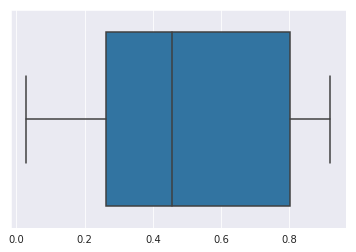

In [131]:
sns.boxplot(answer[:, 1]);

In [132]:
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)

def create_download_link(df, title="Download CSV file", filename="data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '''<a download="{filename}" href="data:text/csv;
            base64,{payload}" target="_blank">{title}</a>'''
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [133]:
answer = pd.DataFrame(answer[:, 1])

In [134]:
create_download_link(answer)